<a href="https://colab.research.google.com/github/shimo8810/machine_intelligence/blob/master/deep_learning/colab/SRResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRResNet(Single Image Super-resolution)


In [1]:
!curl https://colab.chainer.org/install | sh -
!pip install -q chainercv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   7454      0 --:--:-- --:--:-- --:--:--  7454
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develop

In [0]:
from pathlib import Path
from PIL import Image
from chainercv import transforms
import cupy as cp
from tqdm import tqdm

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.dataset import dataset_mixin
from chainer import training
from chainer.training import extensions

## Load Data from Google Drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_valid_HR.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_train_HR.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_train_LR_bicubic_X4.zip'
!unzip -qq -n 'gdrive/My Drive/Data/Set5/Set5.zip'

## Parameter

In [0]:
epoch = 300
batchsize = 64

out_dir = 'sr_result'

## Dataset

In [0]:
class DIV2KDataset(dataset_mixin.DatasetMixin):
    def __init__(self, scale=4, size=64, dataset='valid'):
        assert scale in [2, 3, 4], "scale parameter must be 2, 3 or 4."
        assert dataset in ['train', 'valid'], "scale parameter must be 2, 3 or 4."

        self.scale = scale
        self.size = size
        lr_paths = sorted(Path('DIV2K_{}_LR_bicubic/X{}'.format(dataset, scale)).iterdir())
        hr_paths = sorted(Path('DIV2K_{}_HR'.format(dataset)).iterdir())
        assert len(lr_paths) == len(hr_paths), "the number of HR images must be same as the number of LR images."
        self.data = []
        c = 0
        for lr_p, hr_p in tqdm(zip(lr_paths, hr_paths)):
            c += 1
            # load images
            image_lr = np.array(Image.open(lr_p)) \
                .astype(np.float32).transpose(2, 0, 1) / 255.
            image_hr = np.array(Image.open(hr_p)) \
                .astype(np.float32).transpose(2, 0, 1) / 255.

            self.data.append([image_lr, image_hr])
            
            # すべてのデータセットを読み込めないので
            if dataset == 'valid' and c >= 20:
                break
            if dataset == 'train' and c >= 200:
                break

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        # crop images
        image_lr, image_hr = self.data[i]
        image_lr, sl = transforms.random_crop(image_lr,
                            (self.size, self.size), return_param=True)
        image_hr = image_hr[:, sl['y_slice'].start*self.scale:sl['y_slice'].stop*self.scale,
                    sl['x_slice'].start*self.scale: sl['x_slice'].stop*self.scale]
        return image_lr, image_hr

## Network

In [0]:
class ResBlock(chainer.Chain):
    def __init__(self):
        init_w = chainer.initializers.HeNormal()
        
        super(ResBlock, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn1 = L.BatchNormalization(64)
            self.pr1 = L.PReLU()
            self.conv2 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn2 = L.BatchNormalization(64)

    def forward(self, x):
        h = self.pr1(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return h + x

class SRResNet(chainer.Chain):
    def __init__(self):
        init_w = chainer.initializers.HeNormal()
        
        super(SRResNet, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64,
                            ksize=9, stride=1, pad=4, initialW=init_w)
            self.pr1 = L.PReLU()
            
            self._forward = []
            for i in range(2, 16+2):
                name = 'res{}'.format(i)
                self._forward.append(name)
                resblock = ResBlock()
                setattr(self, name, resblock)

            self.conv18 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn18 = L.BatchNormalization(64)
            
            self.conv19 = L.Convolution2D(None, 256,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.pr19 = L.PReLU()

            self.conv20 = L.Convolution2D(None, 256,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.pr20 = L.PReLU()
            self.conv21 = L.Convolution2D(None, 3,
                            ksize=9, stride=1, pad=4, initialW=init_w)

    def forward(self, x, t):
        y = self.enhance(x)
        loss = F.mean_squared_error(y, t)
        chainer.report({'loss': loss}, self)
        return loss
    
    def enhance(self, x):
        h_skip = self.pr1(self.conv1(x))
        h = h_skip
        for name in self._forward:
            l = getattr(self, name)
            h = l(h)
        h = self.bn18(self.conv18(h)) + h_skip
        h = self.pr19(F.depth2space(self.conv19(h), 2))
        h = self.pr20(F.depth2space(self.conv20(h), 2))
        y = self.conv21(h)
        return y

## Load Dataset

In [8]:
train = DIV2KDataset(dataset='train')
test = DIV2KDataset(dataset='valid')
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                repeat=False, shuffle=False)

199it [00:36,  4.94it/s]
0it [00:00, ?it/s]
1it [00:00,  5.11it/s]
2it [00:00,  5.09it/s]
3it [00:00,  4.78it/s]
4it [00:00,  4.87it/s]
5it [00:01,  4.97it/s]
6it [00:01,  5.09it/s]
7it [00:01,  5.33it/s]
8it [00:01,  5.41it/s]
9it [00:01,  5.12it/s]
10it [00:01,  4.90it/s]
11it [00:02,  4.96it/s]
12it [00:02,  4.78it/s]
13it [00:02,  4.84it/s]
14it [00:02,  5.06it/s]
15it [00:02,  5.17it/s]
16it [00:03,  5.13it/s]
17it [00:03,  5.04it/s]
18it [00:03,  4.65it/s]
19it [00:03,  4.60it/s]

## Train

In [11]:
model = SRResNet()

# Setup an optimizer
optimizer = chainer.optimizers.Adam(alpha=10e-4)
optimizer.setup(model)

# Set up an updater
updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=0)

# Set up a Trainer
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

#Set up Updater Extentions
trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.ExponentialShift("alpha", 0.9), trigger=(50, 'epoch'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.snapshot_object(
    model, filename='model_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))

# start training
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           2.98417     3165.06               26.04         
2           0.498215    245.065               49.3398       
3           0.263219    21.0401               72.6501       
4           0.162985    7.5218                95.9556       
5           0.111978    3.1149                119.261       
6           0.0902297   1.14138               142.565       
7           0.0763226   0.369479              165.869       
8           0.0604187   0.180762              189.141       
9           0.0504432   0.107113              219.939       
10          0.0423317   0.0576837             243.242       
11          0.0390616   0.0570326             268.386       
12          0.0370352   0.0416522             291.684       
13          0.0327559   0.0349823             314.983       
14          0.0292986   0.0356645             338.297       
15          0.0285049   0.0311626             361.601       
16          0.0271126   0.

## Loss Curve

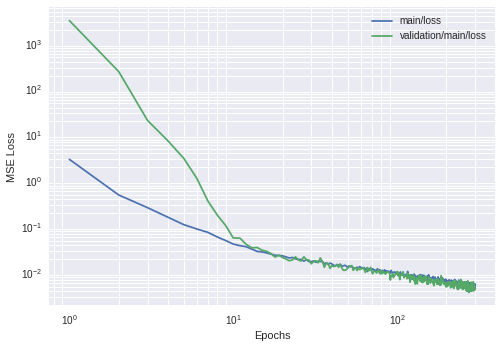

In [17]:
log_data = pd.read_json('sr_result/log')
plt.plot(log_data['epoch'],
         log_data['main/loss'], label='main/loss')
plt.plot(log_data['epoch'],
         log_data['validation/main/loss'], label='validation/main/loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(which="both")
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.show()

## Super-Resolution

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


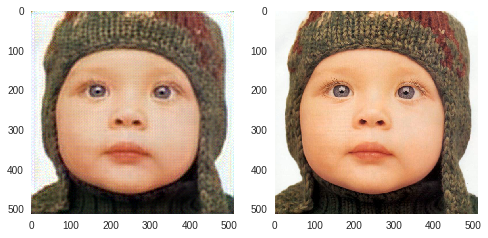

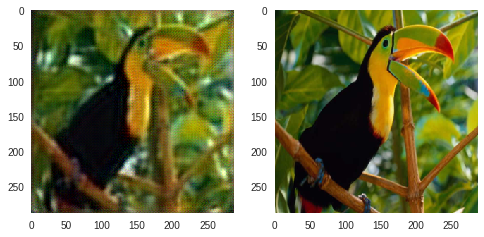

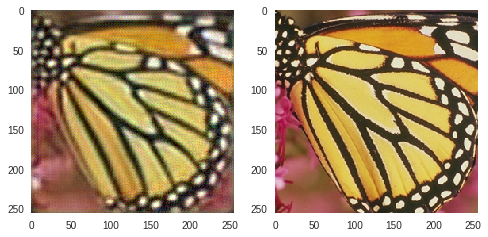

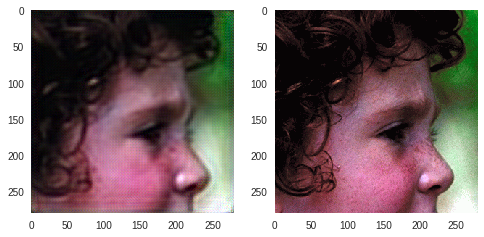

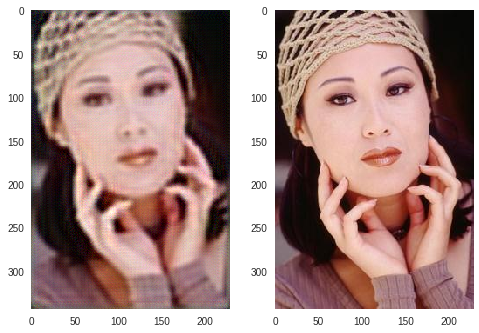

In [15]:
image_hr_paths = sorted(Path('Set5/HR').resolve().iterdir())
image_lr_paths = sorted(Path('Set5/LRx4').resolve().iterdir())

for hr_p, lr_p in zip(image_hr_paths, image_lr_paths):
    x_in = cp.array(Image.open(lr_p)) \
             .transpose(2, 0, 1)[cp.newaxis, :].astype(np.float32) / 255.
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        x_out = model.enhance(x_in).array
    _, _, w, h = x_out.shape
    x_out = cp.asnumpy(x_out.reshape(3, w, h).transpose(1, 2, 0))
    x_out = cp.clip(x_out*255, 0, 255).astype(np.uint8)
    
    fig, (a1, a2) = plt.subplots(1, 2)
    Image.fromarray(x_out).save('SR_' + hr_p.name)
    a1.imshow(x_out)
    a1.grid(False)
    a2.imshow(Image.open(hr_p))
    a2.grid(False)
    fig.show()